Прежде всего загрузим библиотеки, которые потребуются нам в процессе работы.

Let's begin with importing all the crucial libraries we'll need for work.

In [1]:
import pandas as pd 
import numpy as np
import re
from datetime import datetime as dt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Укажем пути к используемым файлам данных.
Set the paths to the data files used.

In [2]:
TRAIN_FILENAME = 'data/new_data_99_06_03_13_04.csv'
TEST_FILENAME = 'data/test.csv'
SAMPLE_FILENAME = 'data/sample_submission.csv'

Чтобы определить качество работы модели, нам необходима метрика.
В этом соревновании метрика показывает, какую долю от реальной цены составляет ошибка предсказания.

In order to evaluate the quality of the model performance, a metric is needed. The metric for this competition is called MAPE (mean absolute percentage error) and shows what fraction of the real price is the prediction error.

$$MAPE=\frac{1}{n}\sum_{t=1}^{n}\frac{\left | Y_t-\hat{Y_t} \right |}{Y_t}$$

In [3]:
def mape(y_real, y_pred):
    return np.mean(np.abs((y_pred - y_real) / y_real))

Зафиксируем некоторые параметры, которые понадобятся нам в дальнейшем.

Set some constants for the future use.

In [4]:
RANDOM_SEED = 13
VERSION = 'last_10'

## Изучение и предобработка данных
## Data overview and preprocessing

Для начала загрузим датасеты и посмотрим, что представляют из себя данные.

First, let's load the preprepared data and look at its main components.

In [5]:
# Подгружаем обучающий датасет и сразу удаляем дубликаты
# Load the training dataset and immediately drop possible duplicates
df_train = pd.read_csv(TRAIN_FILENAME, index_col=0) 
df_train = df_train.drop_duplicates().reset_index(drop=True)

# Подгружаем тестовый датасет
# Load the testing dataset
df_test = pd.read_csv(TEST_FILENAME)

# Загрузим образец для submission
# Load the submission sample
sample_submission = pd.read_csv(SAMPLE_FILENAME)


# Воспользуемся парой функций, чтобы наглядно представить информацию
# Use a couple of functions to visualize the info
dataset_info = lambda df: pd.DataFrame({
    'Shape': [df.shape] + ['' for x in range(len(df.columns) - 1)], 
    'Columns': df.columns, 
    'Non-Null Count': [df[col].count() for col in df.columns]
})

pd.concat([dataset_info(df_train), dataset_info(df_test)], 
          keys=['↓ ОБУЧАЮЩАЯ ВЫБОРКА ↓', '↓ ТЕСТОВАЯ ВЫБОРКА ↓'], 
          axis=1, sort=False).fillna('')

↓ ОБУЧАЮЩАЯ ВЫБОРКА ↓                                       \
                   Shape               Columns Non-Null Count   
0           (109080, 21)              bodyType       109079.0   
1                                        brand       109080.0   
2                                        color       109080.0   
3                                     fuelType       109080.0   
4                                    modelDate       109079.0   
5                                         name       109079.0   
6                                numberOfDoors       109079.0   
7                               productionDate       109080.0   
8                         vehicleConfiguration       109079.0   
9                           engineDisplacement       109079.0   
10                                 enginePower       109079.0   
11                                 description       105829.0   
12                                     mileage       109080.0   
13                                Комплектация       109080.0   
14                                      Привод       109079.0   
15                                        Руль       109080.0   
16                                   Владельцы       109073.0   
17                                         ПТС       109078.0   
18                                     Таможня       109080.0   
19                                    Владение        39889.0   
20                                       Price       109080.0   
21                                                              
22                                                              

   ↓ ТЕСТОВАЯ ВЫБОРКА ↓                                       
                  Shape               Columns Non-Null Count  
0           (35990, 23)              bodyType          35990  
1                                       brand          35990  
2                                       color          35990  
3                                    fuelType          35990  
4                                   modelDate          35990  
5                                        name          35990  
6                               numberOfDoors          35990  
7                              productionDate          35990  
8                        vehicleConfiguration          35990  
9                         vehicleTransmission          35990  
10                         engineDisplacement          35990  
11                                enginePower          35990  
12                                description          35990  
13                                    mileage          35990  
14                               Комплектация          35990  
15                                     Привод          35990  
16                                       Руль          35990  
17                                  Состояние          35990  
18                                  Владельцы          35990  
19                                        ПТС          35990  
20                                    Таможня          35990  
21                                   Владение          15370  
22                                         id          35990

Теперь посмотрим более детализированную информацию по каждому из признаков:

Now consider a detailed information for each of the features:

In [6]:
# Вспомогательная функция
# Helper func
def features_info(df):
    return pd.DataFrame({
        'dtypes' : df.dtypes.values, 
        'nunique': df.nunique().values, 
        'isna'   : df.isna().sum().values, 
        'unique' : {x: df[x].unique() for x in df}
    }, index=df.loc[0].index)

pd.set_option('max_colwidth', 80)

pd.concat([features_info(df_train), features_info(df_test)], 
          keys=['↓ df_train ↓', '↓ df_test ↓'], 
          axis=1, sort=False).fillna('-')

↓ df_train ↓                    \
                           dtypes  nunique     isna   
bodyType                   object    112.0      1.0   
brand                      object     13.0      0.0   
color                      object     16.0      0.0   
fuelType                   object      6.0      0.0   
modelDate                 float64     70.0      1.0   
name                       object   3490.0      1.0   
numberOfDoors             float64      5.0      1.0   
productionDate              int64     73.0      0.0   
vehicleConfiguration       object      4.0      1.0   
engineDisplacement         object    431.0      1.0   
enginePower               float64    330.0      1.0   
description                object  90095.0   3251.0   
mileage                     int64  23363.0      0.0   
Комплектация               object   6883.0      0.0   
Привод                     object      3.0      1.0   
Руль                       object      2.0      0.0   
Владельцы                 float64      3.0      7.0   
ПТС                        object      2.0      2.0   
Таможня                      bool      1.0      0.0   
Владение                   object    289.0  69191.0   
Price                       int64   5709.0      0.0   
vehicleTransmission             -        -        -   
Состояние                       -        -        -   
id                              -        -        -   

                                                                                                       \
                                                                                               unique   
bodyType              [Седан, Универсал 5 дв., Хэтчбек 5 дв. Sportback, Хэтчбек 3 дв., Хэтчбек 5 д...   
brand                 [AUDI, BMW, HONDA, INFINITI, LEXUS, MERCEDES, MITSUBISHI, NISSAN, SKODA, SUZ...   
color                 [040001, CACECB, 97948F, 0000CC, 4A2197, EE1D19, FAFBFB, 007F00, 22A0F8, 660...   
fuelType                                          [бензин, дизель, гибрид, электро, газ, внедорожник]   
modelDate             [1990.0, 1988.0, 1982.0, 1976.0, 1983.0, 1979.0, 1986.0, 1991.0, 1978.0, 198...   
name                  [2.3 MT (133 л.с.), 2.0 MT (115 л.с.), 2.8 AT (174 л.с.), 2.8 MT (174 л.с.) ...   
numberOfDoors                                                          [4.0, 5.0, 3.0, 2.0, 0.0, nan]   
productionDate        [1991, 1989, 1993, 1992, 1990, 1987, 1994, 1988, 1986, 1985, 1984, 1983, 198...   
vehicleConfiguration                                    [MECHANICAL, AUTOMATIC, ROBOT, VARIATOR, nan]   
engineDisplacement    [2.3, 2.0, 2.8, 2.2, 1.8, 2.0d, S4, 2.6, 2.1, 1.9, 1.6d, 1.6, 1.3, 3.3, 1.4,...   
enginePower           [133.0, 115.0, 174.0, 138.0, 90.0, 112.0, 137.0, 75.0, 136.0, 70.0, 230.0, 8...   
description           [\nБыстрым торг.Обмен интересен на авто с неисправным двигателем. \nДоброго ...   
mileage               [10000, 300000, 205636, 450000, 275250, 271800, 370000, 303000, 411000, 5717...   
Комплектация          [{'id': '0'}, {'id': '20717295', 'name': 'Ambition', 'available_options': ['...   
Привод                                                                [передний, полный, задний, nan]   
Руль                                                                                    [LEFT, RIGHT]   
Владельцы                                                                        [3.0, 2.0, 1.0, nan]   
ПТС                                                                        [ORIGINAL, DUPLICATE, nan]   
Таможня                                                                                        [True]   
Владение              [nan, {'year': 2013, 'month': 8}, {'year': 2015, 'month': 8}, {'year': 2020,...   
Price                 [135000, 42000, 200000, 119000, 125000, 185000, 130000, 145000, 110000, 1550...   
vehicleTransmission                                                                                 -   
Состояние                                                             

Очевидно, что данные обучающей и тестовой выборки не совпадают в нескольких местах, и мы должны привести их в соответствие. 
Для этого напишем специальные функции препроцессинга отдельно для трейна и для теста.

As we can see, our train and test datasets don't match well enough, so some adjustment is a must.
To do this, let's write special preprocessing functions singly for each of the dataframes.

In [7]:
def train_preprocessing(train):
    BODY_TYPES = sorted(list(df_test.bodyType.unique()), reverse=True)

    COLORS_MAP = {'CACECB': 'серебристый', 'FAFBFB': 'белый', 'EE1D19': 'красный', 
                  '97948F': 'серый', '660099': 'пурпурный', '040001': 'чёрный', 
                  '4A2197': 'фиолетовый', '200204': 'коричневый', '0000CC': 'синий', 
                  '007F00': 'зелёный', 'C49648': 'бежевый', '22A0F8':'голубой', 
                  'DEA522': 'золотистый', 'FFD600': 'жёлтый', 'FF8649': 'оранжевый', 
                  'FFC0CB':'розовый'}

    train.drop(['Таможня'], axis=1, inplace=True)
    train.dropna(axis = 0, thresh=18, inplace=True)

    def bodyType(row):
        for bt in BODY_TYPES:
            if row.lower().startswith(bt):
                return bt
    train['bodyType'] = train['bodyType'].apply(bodyType)
    
    train['color'] = train['color'].map(COLORS_MAP)
    train['Руль'] = train['Руль'].map({'LEFT': 'Левый', 'RIGHT': 'Правый'})
    train['ПТС'] = train['ПТС'].map({'ORIGINAL': 'Оригинал', 
                                     'DUPLICATE': 'Дубликат'}).fillna('Оригинал')

    def make_ownership():
        lingua_years = lambda y: f'{y} ' + {
            y % 10 == 1     : 'год', 
            y % 10 == 0     : 'лет', 
            11 <= y <= 14   : 'лет', 
            5 <= y % 10 <= 9: 'лет', 
            2 <= y % 10 <= 4: 'годa'
        }[1]

        lingua_months = lambda m: f'{m} ' + {
            m == 1     : 'месяц', 
            2 <= m <= 4: 'месяца', 
            m > 4      : 'месяцев',
            m == 0     : 'месяцев'
        }[1]

        def ownership(row):
            if pd.isnull(row): return np.nan
            
            row = eval(row)
            y1, m1 = 2020, 2
            y1_now, m1_now = dt.utcnow().year, dt.utcnow().month
            y2, m2 = row['year'], row['month']

            delta = (y1 - y2) * 12 + m1 - m2            
            if delta < 0: delta = abs((y1_now - y2) * 12 + m1_now - m2)
            if delta == 0: return '0 месяцев'

            y = delta // 12
            m = delta % 12
            U = ' и ' if y * m != 0 else ''
            y = lingua_years(y) if y != 0 else ''
            m = lingua_months(m) if m != 0 else ''
            return y + U + m
        
        train['Владение'] = train['Владение'].apply(ownership)
        
    make_ownership()
    return train

In [8]:
def test_preprocessing(test):
    test = test.drop(['id', 'Состояние', 'Таможня', 'vehicleTransmission'], axis=1)
    
    for feature in ['productionDate', 'mileage']:
        test[feature] = test[feature].astype('int64')
    
    test['vehicleConfiguration'] = test['vehicleConfiguration'].apply(lambda x: x.split()[1])
    test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: x.split()[0])
    test['enginePower'] = test['enginePower'].apply(lambda x: float(x.split()[0]))
    test['Владельцы'] = test['Владельцы'].apply(lambda x: float(x.split()[0]))
    return test

Применим функции приведения и снова посмотрим на данные..

Let's now cast the functions and look at the data again..

In [9]:
train = train_preprocessing(df_train)
test = test_preprocessing(df_test)

pd.concat([features_info(train), features_info(test)], 
          keys=['↓ df_train ↓', '↓ df_test ↓'], 
          axis=1, sort=False).fillna('-')

↓ df_train ↓                 \
                           dtypes nunique   isna   
bodyType                   object      23      0   
brand                      object      13      0   
color                      object      16      0   
fuelType                   object       5      0   
modelDate                 float64      70      0   
name                       object    3490      0   
numberOfDoors             float64       5      0   
productionDate              int64      73      0   
vehicleConfiguration       object       4      0   
engineDisplacement         object     431      0   
enginePower               float64     330      0   
description                object   90094   3250   
mileage                     int64   23363      0   
Комплектация               object    6882      0   
Привод                     object       3      0   
Руль                       object       2      0   
Владельцы                 float64       3      6   
ПТС                        object       2      0   
Владение                   object     287  69190   
Price                       int64    5709      0   

                                                                                                       \
                                                                                               unique   
bodyType              [седан, универсал 5 дв., хэтчбек 5 дв., хэтчбек 3 дв., кабриолет, купе, лифт...   
brand                 [AUDI, BMW, HONDA, INFINITI, LEXUS, MERCEDES, MITSUBISHI, NISSAN, SKODA, SUZ...   
color                 [чёрный, серебристый, серый, синий, фиолетовый, красный, белый, зелёный, гол...   
fuelType                                                       [бензин, дизель, гибрид, электро, газ]   
modelDate             [1990.0, 1988.0, 1982.0, 1976.0, 1983.0, 1979.0, 1986.0, 1991.0, 1978.0, 198...   
name                  [2.3 MT (133 л.с.), 2.0 MT (115 л.с.), 2.8 AT (174 л.с.), 2.8 MT (174 л.с.) ...   
numberOfDoors                                                               [4.0, 5.0, 3.0, 2.0, 0.0]   
productionDate        [1991, 1989, 1993, 1992, 1990, 1987, 1994, 1988, 1986, 1985, 1984, 1983, 198...   
vehicleConfiguration                                         [MECHANICAL, AUTOMATIC, ROBOT, VARIATOR]   
engineDisplacement    [2.3, 2.0, 2.8, 2.2, 1.8, 2.0d, S4, 2.6, 2.1, 1.9, 1.6d, 1.6, 1.3, 3.3, 1.4,...   
enginePower           [133.0, 115.0, 174.0, 138.0, 90.0, 112.0, 137.0, 75.0, 136.0, 70.0, 230.0, 8...   
description           [\nБыстрым торг.Обмен интересен на авто с неисправным двигателем. \nДоброго ...   
mileage               [10000, 300000, 205636, 450000, 275250, 271800, 370000, 303000, 411000, 5717...   
Комплектация          [{'id': '0'}, {'id': '20717295', 'name': 'Ambition', 'available_options': ['...   
Привод                                                                     [передний, полный, задний]   
Руль                                                                                  [Левый, Правый]   
Владельцы                                                                        [3.0, 2.0, 1.0, nan]   
ПТС                                                                              [Оригинал, Дубликат]   
Владение              [nan, 6 лет и 6 месяцев, 4 годa и 6 месяцев, 0 месяцев, 11 месяцев, 5 лет и ...   
Price                 [135000, 42000, 200000, 119000, 125000, 185000, 130000, 145000, 110000, 1550...   

                     ↓ df_test ↓                    \
                          dtypes  nunique     isna   
bodyType                  object     23.0      0.0   
brand                     object     13.0      0.0   
color                     object     16.0      0.0   
fuelType                  object      5.0      0.0   
modelDate                float64     51.0      0.0   
name                      object   2528.0      0.0   
numberOfDoors            float64      4.0      0.0   
productionDate             int64     49.0      0.0   
vehicleConfiguration     

Гораздо лучше!

Much better!

## Конструирование признаков
## Feature engineering

У нас уже достаточно значимых признаков, но чтобы модель работала лучше, мы можем добавить новые.
Посмотрим, что это может быть. Начнем с того, что объединим выборки для удобства обработки.

We already have a plenty of valuable features, but in order to make the model even better we can add some more. 
Let's see what else we can do. We'll begin with merging the training and testing sets for convenience.

In [10]:
train['sample'] = 1
test['sample'] = 0
test['Price'] = 0
data = test.append(train, sort=False).reset_index(drop=True)

features_info(data)

,dtypes,nunique,isna,unique
bodyType,object,23,0,"[внедорожник 5 дв., седан, хэтчбек 5 дв., внедорожник 3 дв., лифтбек, купе-х..."
brand,object,13,0,"[MERCEDES, INFINITI, NISSAN, BMW, VOLKSWAGEN, MITSUBISHI, TOYOTA, VOLVO, SKO..."
color,object,16,0,"[синий, чёрный, белый, серый, серебристый, красный, фиолетовый, бежевый, зел..."
fuelType,object,5,0,"[бензин, дизель, гибрид, газ, электро]"
modelDate,float64,70,0,"[2015.0, 2014.0, 2009.0, 2013.0, 2007.0, 2006.0, 2012.0, 2010.0, 2003.0, 200..."
name,object,3608,0,"[250 2.0 AT (211 л.с.) 4WD, 3.7 AT (333 л.с.) 4WD, 1.6 AT (110 л.с.), M50d 3..."
numberOfDoors,float64,5,0,"[5.0, 4.0, 3.0, 2.0, 0.0]"
productionDate,int64,73,0,"[2017, 2014, 2013, 2016, 2015, 2008, 2007, 2012, 2006, 2010, 1995, 2003, 200..."
vehicleConfiguration,object,4,0,"[AUTOMATIC, ROBOT, VARIATOR, MECHANICAL]"
engineDisplacement,object,437,0,"[2.0, 3.7, 1.6, 3.0, 1.8, 3.5, 2.5, 3.8, 4.5, 4.8, 3.2, 5.5, 3.6, 2.4, 1.4, ..."


Итак, мы до сих пор не принимали во внимание признак 'description', который наверняка может содержать в себе важную и полезную для обучения модели информацию.

So, the 'description' feature has remained untouched so far. However, it for sure may contain some significant and useful information for the model to learn.

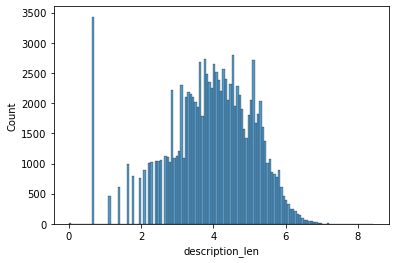

In [13]:
data['description'] = data['description'].fillna('[]')
data['description_len'] = data['description'].apply(lambda x: len(x.split()))

sns.histplot(np.log1p(data.query('sample == 1')['description_len']));

Мы решили извлечь информацию о комплектующих и отделке автомобиля, которая могла бы, по нашему мнению, повлиять на его конечную стоимость.

We decided to extract information about car equipment and finishing, which in our opinion could affect the final price of a car.

In [14]:
# Приведем текст описания к нижнему регистру
# Bring the description text to lowercase
data['description'] = data['description'].apply(lambda x: x.lower())

In [15]:
# Сконструируем dummy variables для признака 'description'
# Construct dummy variables for the 'description' feature

DESCRIPTION_PATTERN = {
    "leather"                 : "( 'темный' or 'тёмный' ) and 'салон'", 
    "carter"                  : "'защита' and 'картера'", 
    "ABS"                     : "'антиблокировочная' and 'система'", 
    "airbags"                 : "'подушки' and 'безопасности'", 
    "immob"                   : "'иммобилайзер'", 
    "central_locking"         : "'центральный' and 'замок'", 
    "on_board_computer"       : "'бортовой' and 'компьютер'", 
    "cruise_control"          : "'круиз-контроль' or 'круиз'", 
    "climat_control"          : "'климат-контроль' or 'климат'", 
    "multi_rudder"            : "'мультифункциональный' and 'руль'", 
    "power_steering"          : "( 'гидроусилитель' or 'гидро' or 'усилитель' ) and 'руля'", 
    "light_and_rain_sensors"  : "'датчики' and 'света' and 'дождя'", 
    "сarbon_body_kits"        : "'карбоновые' and 'обвесы'", 
    "rear_diffuser_rkp"       : "'задний' and 'диффузор'", 
    "door_closers"            : "'доводчики' and 'дверей'", 
    "rear_view_camera"        : "( 'камера' or 'видеокамера' ) and 'заднего' and 'вида'", 
    "amg"                     : "'amg'", 
    "bi_xenon_headlights"     : "( 'биксеноновые' or 'биксенон' ) and 'фары'", 
    "car_dealer"              : "'рольф' or 'панавто' or 'дилер' or 'кредит' or 'ликвидация'", 
    "alloy_wheels"            : "'легкосплавные' or 'колесные' or 'диски'", 
    "parking_sensors"         : "'парктроник' or 'парктронник'", 
    "dents"                   : "'вмятины' or 'вмятина' or 'царапина' or 'царапины' or 'трещина'", 
    "roof_with_panoramic_view": "'панорамная' and 'крыша'"
}

def compose_query(pattern):
    query = ''
    for w in pattern.split():
        query += w + (' ' if w in ['or', 'and', '(', ')'] else ' in x ')
    return eval(f'lambda x: {query}')

Queries = {f: compose_query(p) for f, p in DESCRIPTION_PATTERN.items()}

for feature in DESCRIPTION_PATTERN:
    data[feature] = data['description'].apply(
        lambda descr: int(Queries[feature](descr))
    )

In [16]:
data['model_reference'] = data['name'].apply(lambda x: x.split()[0])

Кроме этого, извлечем из текста некоторые общие признаки с помощью векторизации.

In addition, let's extract some general features from the text via converting it to a matrix of token counts.

In [17]:
vectorizer = CountVectorizer()
text_feat = vectorizer.fit_transform(data['description'])
data['mean'] = text_feat.mean(axis=1)
data['sum'] = text_feat.sum(axis=1)

Также попытаемся отыскать хотя бы самую незначительную отсылку к модели автомобиля в признаке 'name'.

Let's also try to find at least some faint reference to a car model in the 'name' feature.

In [18]:
data['model_reference'] = data['name'].apply(lambda x: x.split()[0])

Почистим колонку 'engineDisplacement'.

Unify the 'engineDisplacement' column.

In [19]:
def engineDisplacement(row):
    engine = re.findall('\d\.\d', str(row))
    return float(engine[0]) if engine != [] else None

data['engineDisplacement'] = data['name'].apply(engineDisplacement)

Заменим строковые значения для признака 'Владение' на общее количество месяцев.

Convert 'Владение' feature string values to the total number of months.

In [20]:
def months_of_ownership(row):
    if pd.isnull(row): return
    s = row.replace('и', '').split()
    if len(s) == 2:
        return int(s[0]) * (1 if 'месяц' in s[1] else 12)
    else:
        return int(s[0]) * 12 + int(s[2])
    
data['Владение'] = data['Владение'].apply(months_of_ownership)

Заполним пропуски.

Fill the missing values.

In [21]:
data['Владение_is_none'] = pd.isna(data['Владение']).astype('uint8')
data['Владельцы'] = data['Владельцы'].fillna(3.0)
data['Владение'] = data['Владение'].fillna(
    data.query('sample == 1')['Владение'].median()
)

Добавим еще пару преобразований

Apply a few more transformations

In [22]:
data['modelDate'] = 2020 - data['modelDate']
data['productionDate'] = 2020 - data['productionDate']
data['prod-model'] = data['productionDate'] - data['modelDate']

..и сделаем one-hot-encoding.

..and finally, make one-hot-encoding.

In [23]:
data = pd.get_dummies(data, columns=['bodyType', 'brand', 'color', 
                                     'fuelType', 'vehicleConfiguration',
                                     'Привод', 'Руль', 'Владельцы', 'ПТС', 
                                     'engineDisplacement', 'model_reference'], 
                      dummy_na=True)

Выкидываем лишние признаки.

Drop unnecessary features.

In [24]:
data.drop(['description', 'Комплектация', 'name', 'Владение'], 
          axis=1, inplace=True)

Напоследок посмотрим на распределение целевого значения.

Before proceeding to the model assembling, let's have a last glance at our target.

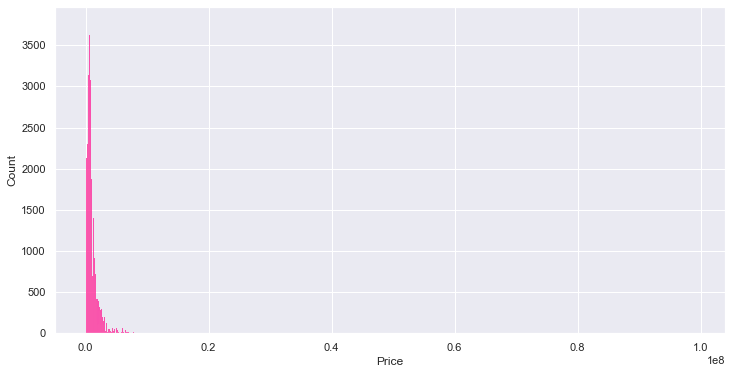

In [25]:
sns.set()
plt.figure(figsize=(12, 6))
sns.histplot(data.query('sample == 1')['Price'], color='#FF1493');

Похоже, что распределение стоимости далеко от нормального. Исправить это можно log-нормализацией.

Looks like the price is far from being normaly distributed. Let's fix this with the help of log normalization.

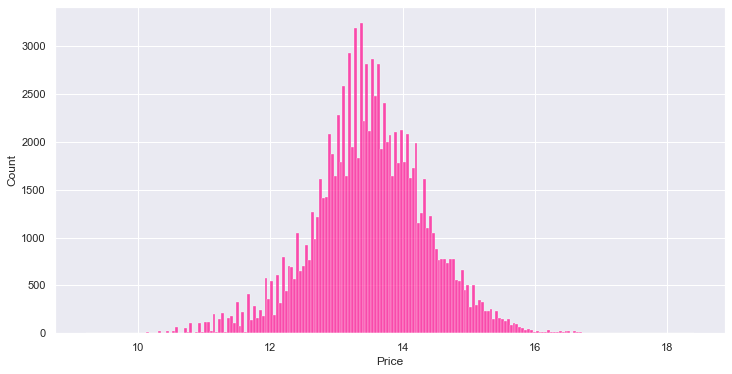

In [28]:
train_data = data.query('sample == 1').drop('sample', axis=1)
test_data = data.query('sample == 0').drop(['sample', 'Price'], axis=1)
train_data['Price'] = np.log(train_data['Price'])

sns.set()
plt.figure(figsize=(12, 6))
sns.histplot(train_data['Price'], color='#FF1493');

## Обучение и тестирование модели

## Model training and testing

**Испробовав множество вариантов, мы в конце концов остановились на ансамбле из RandomForestRegressor и BaggingRegressor с ExtraTreesRegressor в качестве базовой модели и усреднении их предсказаний:**

**After trying out a bunch of different model combinations, we've eventually found the one that seemed to work best, which was the ensemble of RandomForestRegressor and BaggingRegressor with ExtraTreesRegressor as the base estimator with averaging their predictions:**

In [29]:
models = [RandomForestRegressor(n_estimators=250, 
                                random_state=RANDOM_SEED, 
                                n_jobs=-1, 
                                verbose=1), 
          BaggingRegressor(ExtraTreesRegressor(random_state=RANDOM_SEED), 
                           random_state=RANDOM_SEED)]


def ensemble_models_predict(models, X, y, test_data):
    pred_stock = np.zeros(len(test_data))
    parts = 0
    
    for model_ in tqdm(models):
        model_.fit(X, y)
        pred_subm = model_.predict(test_data)
        pred_stock += np.round(np.exp(pred_subm), -3)
        parts += 1
        
    y_pred = pred_stock / parts
    return y_pred

Определим значения признаков и целевой переменной

Define the feature values and the target values

In [30]:
X = train_data.drop(['Price'], axis=1).reset_index(drop=True)
y = train_data['Price'].values

Можно переходить к тестированию.
Ниже код, использованный для валидации модели, а также результат его работы (MAPE).

We can now proceed to testing. 
Below's the code used for the model validation with the result of it's work (MAPE score).

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

y_pred = ensemble_models_predict(models, X_train, y_train, X_test)
mape(np.exp(y_test), y_pred)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 250 out of 250 | elapsed:    0.8s finished
100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [29:50<00:00, 895.03s/it]


0.11035407906189643

Модель работает достаточно хорошо, чтобы применить её к тестовой выборке для submission.

The model performs well enough to be trained for the submission.

In [32]:
predicted = ensemble_models_predict(models, X, y, test_data)


# Сформируем submission
# Make the submission
now = dt.now().strftime('[%d.%m.%Y]-[%H-%M]')
sample_submission['price'] = predicted
sample_submission.to_csv(f'submission_v{VERSION}-{now}.csv', index=False)

sample_submission.head(10)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 250 out of 250 | elapsed:    0.9s finished
100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [42:05<00:00, 1262.79s/it]


,id,price
0,0,2236500.0
1,1,1479500.0
2,2,481500.0
3,3,3471000.0
4,4,1137000.0
5,5,652500.0
6,6,345500.0
7,7,566500.0
8,8,1807500.0
9,9,626500.0
